# Segmentation

This is the crucial step - for every augmented image, we need to make and save its own segmentation map as this is the most realistic use-case.  We use a "hot-cold" approach which allows us to both pick out small bright foreground sources (stars, star clusters, ...) and keep the large-scale structure intact. We also deblend the large galaxy gently for high-reds images, and more aggressively at lower resolutions. 

The procedure is:

1. Load the image cutout with its mask, background estimate, etc.

**Hot run**

2. Smooth the image to increase SNR
3. Detect any bright pixels above a `hot_snr_threshold` (at least 5)
4. The main galaxy will be detected - remove it from the segmap and mask the rest
5. Grow the mask based on the size of each detected hot source

**Cold run**

6. Detect all sources larger than 5 px 
7. Deblend the main source

> One change here is that we have many masks running across the image from the chip gap. Before running segmentation, we interpolate over the chip gap

#### Imports

In [1]:
import sys
sys.path.append('../')

from lib.utils import _interpolate_missing_pixels, _enclosed_masked_regions, _segmap, _segmap_cmap, get_segmap, _cent_label, _deblended_mask, segmap_to_rle, grow_segmask
from photutils.segmentation import deblend_sources, detect_sources
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from astropy.io import fits

Load in an augmented image:

In [176]:
catalog = pd.read_csv('../data/catalogs/augments.csv')

galaxy = "ngc4886"
sblim_min = 22.75
sblim_max = 24.5
pxscale_min = 50
pxscale_max = 100

catalog = catalog[(catalog.galaxy == galaxy) & 
                      (catalog.sblim >= sblim_min) & 
                      (catalog.sblim <= sblim_max) & 
                      (catalog.pxscale_pc >= pxscale_min) & 
                      (catalog.pxscale_pc <= pxscale_max)]


# row = data[data.pxscale_pc > 500].sample(n=1).iloc[0]
row = catalog.sample(n=1).iloc[0]
row

galaxy            ngc4886
pxscale_pc         66.931
pxscale_arcsec       0.15
sblim               22.75
Name: 25437, dtype: object

Open up the image file:

In [177]:
file = fits.open(f'../data/augments/{row.galaxy}/px{int(row.pxscale_pc)}_sb{row.sblim:0.2f}.fits')

# Load the relevant arrays and header info
img = file[0].data
err = file['ERR'].data
mask = file['MASK'].data > 0
header = file['SCI'].header
bgsd = header['BGSD']
zp = header['ZP']
pxscale = header['PXSCALE']

mask = mask | np.isinf(img) | np.isnan(img)

# Workaround because I wrote the wrong header down
pxscale = row.pxscale_arcsec
bgsd = np.power(10, (zp-row.sblim)/2.5) * pxscale**2

Plot the image:

/var/folders/_w/6csvq9qx0611l8s_lvbrrpyh0000gn/T/ipykernel_11948/1683982020.py:4: RuntimeWarning: invalid value encountered in divide
  axs[1].imshow(img/err, vmin=0, vmax=5, cmap='gray')


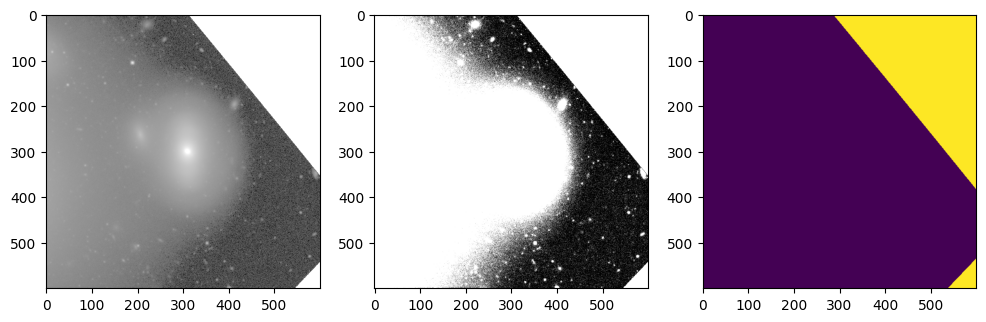

In [147]:
fig, axs = plt.subplots(1, 3, figsize=(12,4))

axs[0].imshow(-2.5*np.log10(np.abs(img)/pxscale**2) + zp, cmap='gray_r', vmin=17, vmax=30)
axs[1].imshow(img/err, vmin=0, vmax=5, cmap='gray')
axs[2].imshow(mask)

## 1. Interpolate NaNs

Our images often have a mask running across the whole image - this makes `photutils.segmentation` split them up into two regions. Before running segmentation, we interpolate over the mask where possible (within the chip), but keep pixels outside the field of view masked.

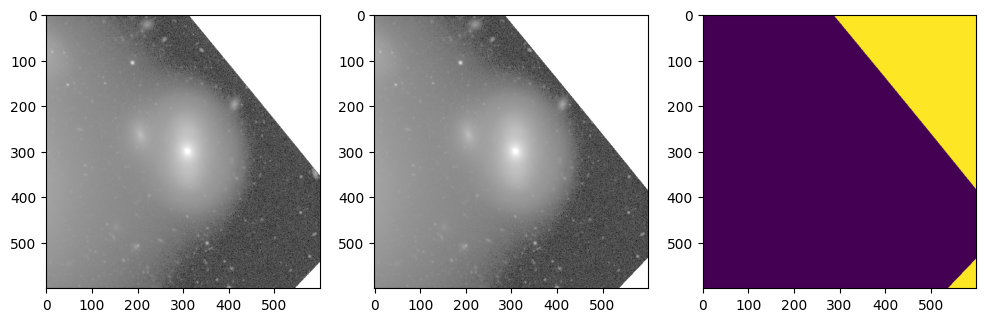

In [148]:
img_interp = _interpolate_missing_pixels(img, mask)


fig, axs = plt.subplots(1, 3, figsize=(12,4))
axs[0].imshow(-2.5*np.log10(np.abs(img)/pxscale**2) + zp, cmap='gray_r', vmin=17, vmax=30)
axs[1].imshow(-2.5*np.log10(np.abs(img_interp)/pxscale**2) + zp, cmap='gray_r', vmin=17, vmax=30)
axs[2].imshow(mask)

## 2. Hot mode

Detect any bright sources in the image that are over `hot_snr x sigma`

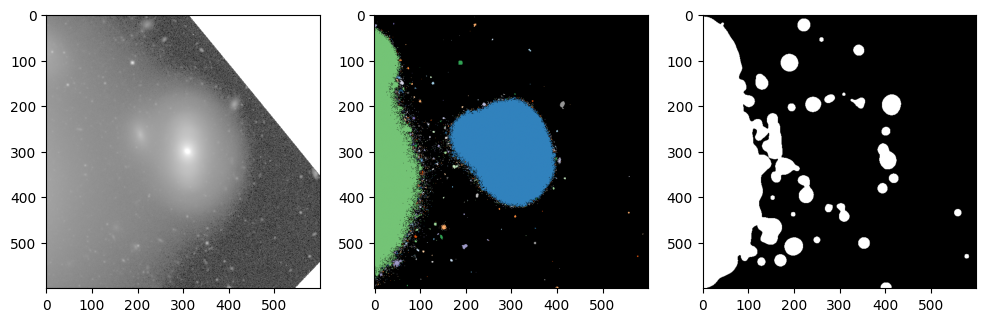

In [155]:
mask_interp = np.isinf(img_interp) | np.isnan(img_interp)
hot = detect_sources(img_interp, threshold=3*bgsd, mask=mask_interp, npixels=1, connectivity=4)
if hot is None:
    segmask_hot = np.zeros_like(img)
else:
    segmask_hot = hot.copy()
    segmask_hot.remove_label(_cent_label(hot, img.shape[0]))
    segmask_hot.relabel_consecutive()
    grow_sigma = max(0.01*img.shape[0], 0.5)
    segmask_hot = grow_segmask(segmask_hot, grow_sigma=grow_sigma, area_norm=5)

# Plot the segmap|
fig, axs = plt.subplots(1, 3, figsize=(12,4))
axs[0].imshow(-2.5*np.log10(np.abs(img)/pxscale**2) + zp, cmap='gray_r', vmin=17, vmax=30)
if hot is not None:
    axs[1].imshow(hot, cmap=_segmap_cmap(hot))
axs[2].imshow(segmask_hot, cmap='gray')

Now mask any pixels that aren't in the central hot mode source.

## 3. Cold mode

Now run an independent cold run with a lower SNR threshold.

* At this stage, do aggressive deblending so we can separate out the host regions for the next stage.

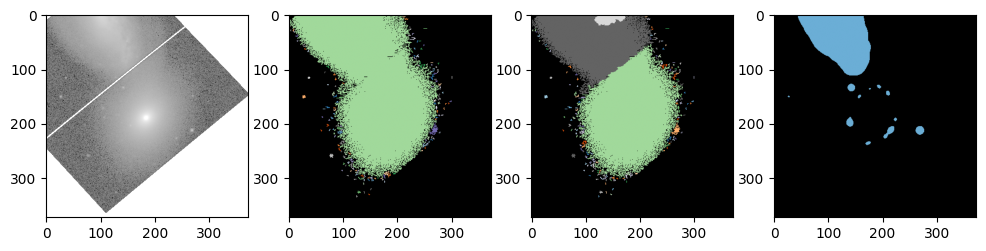

In [1375]:
mask_interp = np.isinf(img_interp) | np.isnan(img_interp)
cold = detect_sources(img_interp, threshold=1.5*bgsd, mask=mask_interp, npixels=5, connectivity=4)
cold_cent = _cent_label(cold, img_interp.shape[0])
cold_deblended = deblend_sources(img_interp, cold, npixels=5, contrast=0.001, progress_bar=False, nlevels=32, labels=cold_cent)


# Plot the segmap|
fig, axs = plt.subplots(1, 4, figsize=(12,4))
axs[0].imshow(-2.5*np.log10(np.abs(img)/pxscale**2) + zp, cmap='gray_r', vmin=17, vmax=30)
axs[1].imshow(cold, cmap=_segmap_cmap(cold))
axs[2].imshow(cold_deblended, cmap=_segmap_cmap(cold_deblended))
axs[3].imshow(segmask_hot, cmap=_segmap_cmap(cold))

## 3. Combining hot + cold

1. Deblend the main source only (aggressively) and start constructing a cold-mode mask.
2. Remove the central deblended region from the mask as this is our main source
3. For every other region, compare the area to the hot mask area.
    * If the overlap is larger than `overlap_thresh` (0.2 default), remove the entire deblended region
    * If the overlap is small, the small hot region caused too much split in the watershed. Mask the hot region, but keep the cold deblended region unmasked.
4. Repeat this for all deblended segments and finally grow the new mask by segment area

**The total mask is: `hot_segmask` (all hot sources, excluding central) ` + cold_segmask` (all cold sources, excluding central) `+ cold_segmask_deblended` (any segments from the central source with a large overlap with the hot mask)**

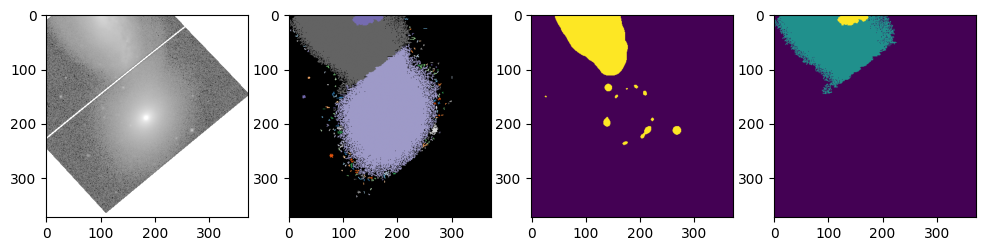

In [1376]:
cent_labels = np.unique(cold_deblended.data[cold.data == cold_cent])
debl_mask = _deblended_mask(cold_deblended, segmask_hot, cent_labels, cold_cent, overlap_thresh=0.2) 

# Plot the segmap
fig, axs = plt.subplots(1, 4, figsize=(12,4))
axs[0].imshow(-2.5*np.log10(np.abs(img)/pxscale**2) + zp, cmap='gray_r', vmin=17, vmax=30)
axs[1].imshow(cold_deblended, cmap=_segmap_cmap(cold_deblended))
axs[2].imshow(segmask_hot)
axs[3].imshow(debl_mask)#, cmap=_segmap_cmap(cold))

Final result - combining all of these functions into `get_segmap`:

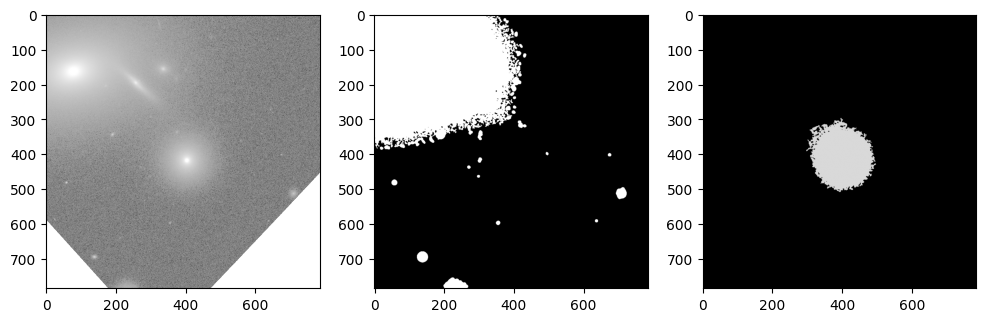

In [178]:
segmask, segmap = get_segmap(img, mask, bgsd, min_area=15, hot_snr=7, cold_snr=2, nlevels=32, contrast=0.001, overlap_thresh=0.2)
fig, axs = plt.subplots(1, 3, figsize=(12,4))
axs[0].imshow(-2.5*np.log10(np.abs(img)/pxscale**2) + zp, cmap='gray_r', vmin=17, vmax=30)
axs[1].imshow(segmask, cmap='gray')
axs[2].imshow(segmap.data, cmap=_segmap_cmap(segmap))